# SENTIMENT ANALYSIS ON TWEETS FOR SOCIAL EVENTS.A CASE STUDY ON RUSSIA-UKRAINE WAR



## MAKING THE NECESSARY IMPORTS AND DOWNLOADS

In [2]:
import numpy as np
import tweepy
import csv
import pandas as pd
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import nltk
import pycountry
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC , SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
import seaborn as sns
from wordcloud import WordCloud
import pickle
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [32]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')

## AUTHENTICATION

In [2]:
consumer_key = "GM8KsruM5ozU2U0aHfHKzppLY"
consumer_secret = "xu2YUGq2Gpci8dJ6OZCJeKMOkHVyNlPIE0nLw0Zze3tFgAF1cb"
access_token = "2605844328-8baTA8wD65bG9lYsB26yNssxOBkR2kN3neLYLGo"
access_token_secret = "biqTND8aQr7RHJPtstUwfF6BUjLuy1YwrqB1EyyNGCS2u"

## CREATING THE FILES

In [3]:
#Here is only of them for demonstation.The rest were made on a different Jupyter notebook.
def create_dataset(consumer_key, consumer_secret, access_token, access_token_secret, hashtag_phrase):
    
    # Twitter authentication and the connection to Twitter API
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    
    # Initializing Tweepy API
    api = tweepy.API(auth, wait_on_rate_limit=True)
    
    # Name of csv file to be created
    fname = "Ukraine_24_02_2022"
    
    # Open the spreadsheet
    with open('%s.csv' % (fname), 'w', encoding="utf-8") as file:
        w = csv.writer(file)
        
        # Write header row (feature column names of your choice)
        w.writerow(['timestamp', 'tweet_text', 'username', 'all_hashtags', 'location', 
                    'followers_count', 'retweet_count', 'favorite_count'])
        
        # For each tweet matching hashtag, write relevant info to the spreadsheet
        for tweet in tweepy.Cursor(api.search, q=hashtag_phrase+' -filter:retweets', lang="en",until="2022-02-27",tweet_mode='extended').items(50000):
            w.writerow([tweet.created_at, 
                        tweet.full_text.replace('\n',' ').encode('utf-8'), 
                        tweet.user.screen_name.encode('utf-8'), 
                        [e['text'] for e in tweet._json['entities']['hashtags']],  
                        tweet.user.location, 
                        tweet.user.followers_count, 
                        tweet.retweet_count, 
                        tweet.favorite_count])

# Enter your hashtag here
hashtag_phrase= "Ukraine"

if __name__ == '__main__':
    create_dataset(consumer_key, consumer_secret, access_token, access_token_secret, hashtag_phrase)


In [6]:
#Passing the tweets from the csv files i created,to  pandas dataframes

twt_24_02_pd = pd.read_csv("Ukraine_24_02_2022_50000_23_24.csv", header=[0])
twt_25_02_pd = pd.read_csv("Ukraine_25_02_2022_50000_23_24.csv", header=[0])
twt_26_02_pd = pd.read_csv("Ukraine_26_02_2022_50000_23_24.csv", header=[0])
twt_27_02_pd = pd.read_csv("Ukraine_27_02_2022_50000_23_24.csv", header=[0])

#Plotting one of them to see how it looks like
twt_27_02_pd.head()

,timestamp,tweet_text,username,all_hashtags,location,followers_count,retweet_count,favorite_count
0,2022-02-27 23:59:59,"b""Rep. Lauren Boebert Says Canada And U.S. 'Ne...",b'kahornback1',[],"New Jersey, USA",0,0,0
1,2022-02-27 23:59:59,"b""@JennaEllisEsq This is so typical of republi...",b'BBullard007',[],"Pittsburgh, PA",374,1,0
2,2022-02-27 23:59:59,"b""I don't remember any war or any political is...",b'Katlysss',[],Deutschland,4383,4,147
3,2022-02-27 23:59:59,"b'@terranova_billy @JonathanHoenig Is the ""fin...",b'1stcitizen',"['OurManVlad', 'Ukraine', 'BidenHarris', 'IAsk...","Baltimore, MD",2326,0,1
4,2022-02-27 23:59:59,b'Ep. 102: Russia Invades Ukraine? Canada Off ...,b'Have2doxies',[],Southern midwest,1224,0,0


In [4]:
twt_27_02_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
timestamp          50000 non-null object
tweet_text         50000 non-null object
username           50000 non-null object
all_hashtags       50000 non-null object
location           31291 non-null object
followers_count    50000 non-null int64
retweet_count      50000 non-null int64
favorite_count     50000 non-null int64
dtypes: int64(3), object(5)
memory usage: 3.1+ MB


## DATA PREPROCESSING

In [87]:
# There are some columns we do not need. Let's drop them out.
twt_27_02_pd.drop(columns=["username", "all_hashtags","followers_count"], axis=1, inplace=True)
twt_26_02_pd.drop(columns=["username", "all_hashtags","followers_count"], axis=1, inplace=True)
twt_25_02_pd.drop(columns=["username", "all_hashtags","followers_count"], axis=1, inplace=True)
twt_24_02_pd.drop(columns=["username", "all_hashtags","followers_count"], axis=1, inplace=True)
# Drop duplicated rows
twt_27_02_pd.drop_duplicates(inplace=True)
twt_26_02_pd.drop_duplicates(inplace=True)
twt_25_02_pd.drop_duplicates(inplace=True)
twt_24_02_pd.drop_duplicates(inplace=True)
# Convert Created at column's type to datatime
twt_27_02_pd["timestamp"] = pd.to_datetime(twt_27_02_pd["timestamp"])
twt_26_02_pd["timestamp"] = pd.to_datetime(twt_26_02_pd["timestamp"])
twt_25_02_pd["timestamp"] = pd.to_datetime(twt_25_02_pd["timestamp"])
twt_24_02_pd["timestamp"] = pd.to_datetime(twt_24_02_pd["timestamp"])
# Print the info
print(twt_27_02_pd.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 5 columns):
timestamp         50000 non-null datetime64[ns]
tweet_text        50000 non-null object
location          31282 non-null object
retweet_count     50000 non-null int64
favorite_count    50000 non-null int64
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 2.3+ MB
None


In [88]:
#Create another column with the tweets text,named "text_preprocessed_tokenized",where i will apply my preprocessing techniques
twt_27_02_pd["text_preprocessed_tokenized"]=twt_27_02_pd['tweet_text']
twt_26_02_pd["text_preprocessed_tokenized"]=twt_26_02_pd['tweet_text']
twt_25_02_pd["text_preprocessed_tokenized"]=twt_25_02_pd['tweet_text']
twt_24_02_pd["text_preprocessed_tokenized"]=twt_24_02_pd['tweet_text']

In [16]:
#Create a function to clean the tweets
def TwtProcessorTokenizer(twt):
    twt = re.sub('#Ukraine','Ukraine', twt) #Replace #Ukraine with Ukraine
    twt = re.sub('#[A-Za-z0-9]+','',twt)    #Remove all the words that start with a hashtag
    twt = re.sub('@[A-Za-z0-9]+','',twt)    #Remove all the words that start with a mention
    twt = re.sub('\\n','',twt)              #Remove the /n from the tweets
    twt = re.sub('[()!?]', '',twt)          #Remove punctuations
    twt = re.sub('\[.*?\]', '', twt)        # -//-
    twt = re.sub('https?:\/\/\S+', '', twt) #Remove links that start with https
    twt = re.sub('www\.[a-z]?\.?(com)+|[a-z]+\.(com)', '', twt)     #Remove links that start with www.
    # Tokenize the words
    tokenized = word_tokenize(twt)
    # Remove the stop words
    tokenized = [token for token in tokenized if token not in stopwords.words("english")]
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokenized = [lemmatizer.lemmatize(token, pos='a') for token in tokenized]
    # Remove non-alphabetic characters and keep the words contains three or more letters
    tokenized = [token for token in tokenized if token.isalpha() and len(token)>2]
    
    return tokenized

In [10]:
#Αpply to the "text_preprocessed_tokenized" column the function i just created

twt_27_02_pd['text_preprocessed_tokenized'] = twt_27_02_pd['text_preprocessed_tokenized'].str.lower().apply(TwtProcessorTokenizer)
twt_26_02_pd['text_preprocessed_tokenized'] = twt_26_02_pd['text_preprocessed_tokenized'].str.lower().apply(TwtProcessorTokenizer)
twt_25_02_pd['text_preprocessed_tokenized'] = twt_25_02_pd['text_preprocessed_tokenized'].str.lower().apply(TwtProcessorTokenizer)
twt_24_02_pd['text_preprocessed_tokenized'] = twt_24_02_pd['text_preprocessed_tokenized'].str.lower().apply(TwtProcessorTokenizer)

In [7]:
#Convert a list to string     
def listToString(s): 
    str1 = " " 
    return (str1.join(s))

In [11]:
#Using the function above to transform the lists in the "text_preprocessed_tokenized" column to strings,
#so i can later apply the textblob.sentiment
twt_27_02_pd['text_preprocessed_tokenized(str)'] = twt_27_02_pd['text_preprocessed_tokenized'].apply(listToString)
twt_26_02_pd['text_preprocessed_tokenized(str)'] = twt_26_02_pd['text_preprocessed_tokenized'].apply(listToString)
twt_25_02_pd['text_preprocessed_tokenized(str)'] = twt_25_02_pd['text_preprocessed_tokenized'].apply(listToString)
twt_24_02_pd['text_preprocessed_tokenized(str)'] = twt_24_02_pd['text_preprocessed_tokenized'].apply(listToString)

In [9]:
# Fill the missing values with unknown tag
twt_27_02_pd["location"].fillna("unknown", inplace=True)
twt_26_02_pd["location"].fillna("unknown", inplace=True)
twt_25_02_pd["location"].fillna("unknown", inplace=True)
twt_24_02_pd["location"].fillna("unknown", inplace=True)
twt_27_02_pd.head()

,timestamp,tweet_text,location,retweet_count,favorite_count,text_preprocessed_tokenized,text_preprocessed_tokenized(str)
0,2022-02-27 23:59:59,"b""Rep. Lauren Boebert Says Canada And U.S. 'Ne...","New Jersey, USA",0,0,"[lauren, boebert, says, canada, liberated, lik...",lauren boebert says canada liberated like ukra...
1,2022-02-27 23:59:59,"b""@JennaEllisEsq This is so typical of republi...","Pittsburgh, PA",1,0,"[typical, republicans, country, pulling, toget...",typical republicans country pulling together c...
2,2022-02-27 23:59:59,"b""I don't remember any war or any political is...",Deutschland,4,147,"[remember, war, political, issue, entire, worl...",remember war political issue entire world unit...
3,2022-02-27 23:59:59,"b'@terranova_billy @JonathanHoenig Is the ""fin...","Baltimore, MD",0,1,"[financial, calamity, sojourn, white, house]",financial calamity sojourn white house
4,2022-02-27 23:59:59,b'Ep. 102: Russia Invades Ukraine? Canada Off ...,Southern midwest,0,0,"[russia, invades, ukraine, canada, rails, olym...",russia invades ukraine canada rails olympics a...


# EXPLORATORY DATA ANALYSIS

In [4]:
# Print the unique locations and number of unique locations
print("Unique Values:",twt_27_02_pd["location"].unique())
print("Unique Value count:",len(twt_27_02_pd["location"].unique()))

Unique Values: ['New Jersey, USA' 'Pittsburgh, PA' 'Deutschland' ... 'Southsea, UK'
 'Reigerpark' 'Right. where I should be!']
Unique Value count: 11454


In [5]:
# Print the unique locations and number of unique locations
print("Unique Values:",twt_26_02_pd["location"].unique())
print("Unique Value count:",len(twt_26_02_pd["location"].unique()))

Unique Values: ['Boston, MA' 'unknown' 'Hampton Roads, VA' ... 'On my way to Mars'
 'Rustbelt City' 'Under the Overpass, Florida']
Unique Value count: 11852


In [6]:
# Print the unique locations and number of unique locations
print("Unique Values:",twt_25_02_pd["location"].unique())
print("Unique Value count:",len(twt_25_02_pd["location"].unique()))

Unique Values: ['Internet' 'Washington, DC ... normally' 'unknown' ... 'Lekki'
 'Brit trapped in Dublin' 'Olympia WA, via Trowvegas U.K.']
Unique Value count: 11791


In [7]:
# Print the unique locations and number of unique locations
print("Unique Values:",twt_24_02_pd["location"].unique())
print("Unique Value count:",len(twt_24_02_pd["location"].unique()))

Unique Values: ['unknown' 'Columbia, MO' 'Accra, Ghana' ... 'Central Jersey'
 'California Kid, on Mars' 'Norfolk, UK']
Unique Value count: 13100


In [94]:
#Remove the spaces from the start or the end of the name of the location,so the function to code the locations that ill create,will work better
twt_27_02_pd['location'] = twt_27_02_pd['location'].str.strip()
twt_26_02_pd['location'] = twt_26_02_pd['location'].str.strip()
twt_25_02_pd['location'] = twt_25_02_pd['location'].str.strip()
twt_24_02_pd['location'] = twt_24_02_pd['location'].str.strip()

In [8]:
print ('Value counts for 27/02/2022')
print(twt_27_02_pd['location'].value_counts())
print ('-------------------------------------------')
print ('Value counts for 26/02/2022')
print(twt_26_02_pd['location'].value_counts())
print ('-------------------------------------------')
print ('Value counts for 25/02/2022')
print(twt_25_02_pd['location'].value_counts())
print ('-------------------------------------------')
print ('Value counts for 24/02/2022')
print(twt_24_02_pd['location'].value_counts())

Value counts for 27/02/2022
unknown                       18710
United States                   811
USA                             427
Canada                          300
Ukraine                         280
                              ...  
Denver/LoHi/La Selva Beach        1
Fort Myers Beach, FL              1
Brampton, Ontario, Canada         1
Fair Oaks, VA                     1
🇬🇷🇺🇸🇬🇧                            1
Name: location, Length: 11453, dtype: int64
-------------------------------------------
Value counts for 26/02/2022
unknown                           18359
United States                       888
USA                                 427
London, England                     290
Canada                              256
                                  ...  
Anywhere but everywhere               1
God Bless the USA 🇺🇸                  1
Kingdom of Wessex - West Saxon        1
Nowy Dwór Mazowiecki, Poland          1
In the water ofc.                     1
Name: location, Leng

In [15]:
#Create a function to display frequency charts
def plot_frequency_charts(df, feature, title, pallete):
    df = df[df.location!='unknown']
    freq_df = pd.DataFrame()
    freq_df[feature] = df[feature]
    
    f, ax = plt.subplots(1,1, figsize=(16,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:30], palette=pallete)
    g.set_title("Number and percentage of {}".format(title))

    #for p in ax.patches:
      #  height = p.get_height()
       # ax.text(p.get_x()+p.get_width()/2.,
           #     height + 3,
             #   '{:1.2f}%'.format(100*height/total),
             #   ha="center") 

    plt.title('Frequency of {} tweeting about Ukrain-Russian War'.format(feature))
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel(title, fontsize=12)
    plt.xticks(rotation=100)
    plt.show()

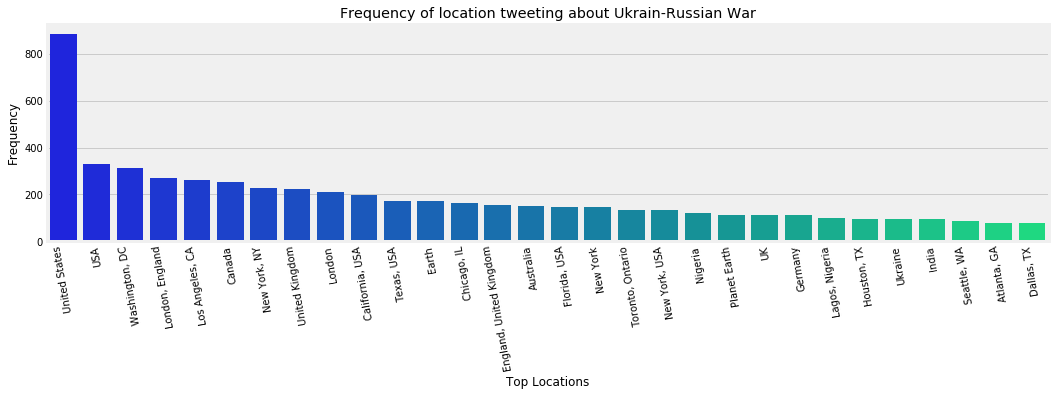

In [16]:
#Use the function above to view most popular tweeting location
plot_frequency_charts(twt_24_02_pd, 'location' ,'Top Locations', 'winter')

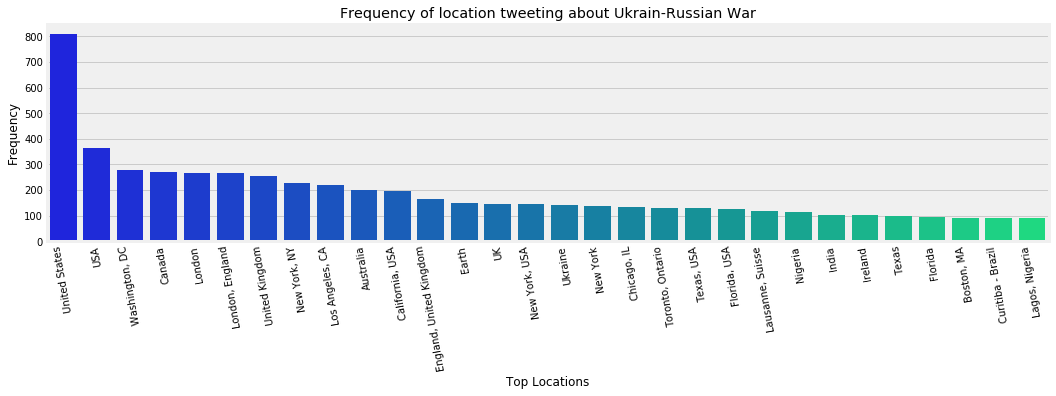

In [17]:
plot_frequency_charts(twt_25_02_pd, 'location' ,'Top Locations', 'winter')

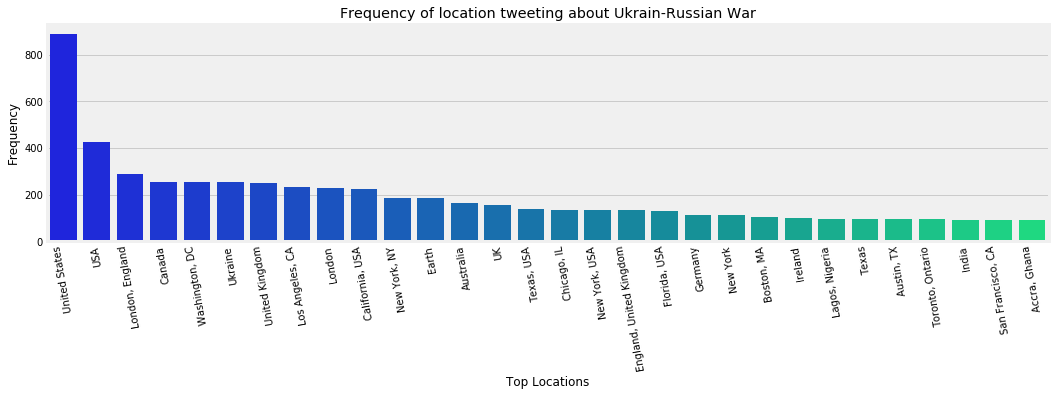

In [18]:
plot_frequency_charts(twt_26_02_pd, 'location' ,'Top Locations', 'winter')

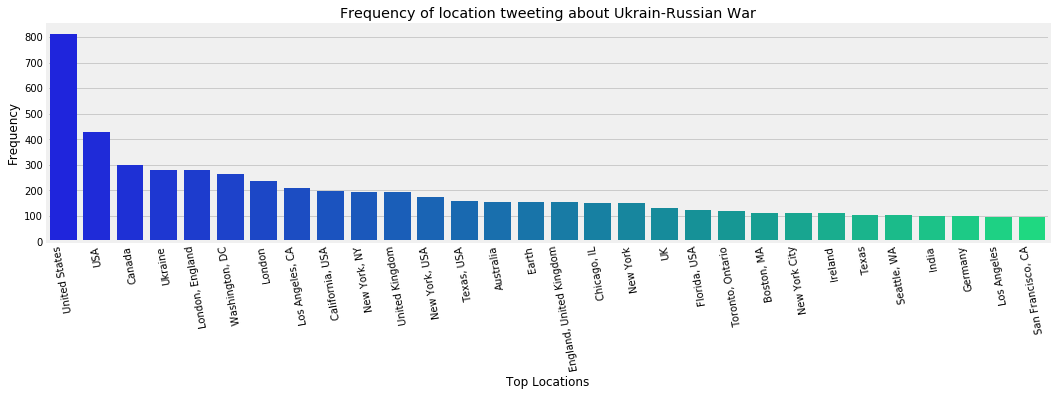

In [19]:
plot_frequency_charts(twt_27_02_pd, 'location' ,'Top Locations', 'winter')

### Let's make it prettier,by grouping the location to country codes 

In [22]:
def get_countries(location):
    
    # If location is a country name return its alpha2 code
    if pycountry.countries.get(name= location):
        return pycountry.countries.get(name = location).alpha_2
    
    # If location is a subdivisions name return the countries alpha2 code
    try:
        pycountry.subdivisions.lookup(location)
        return pycountry.subdivisions.lookup(location).country_code
    except:
        # If the location is neither country nor subdivision return the "unknown" tag
        return "unknown"

In [5]:
# Call the function and store the country codes in the Country column
twt_27_02_pd["country_code"] = twt_27_02_pd["location"].apply(get_countries)
twt_26_02_pd["country_code"] = twt_26_02_pd["location"].apply(get_countries)
twt_25_02_pd["country_code"] = twt_25_02_pd["location"].apply(get_countries)
twt_24_02_pd["country_code"] = twt_24_02_pd["location"].apply(get_countries)

In [7]:
print ('---------------------------------------------------------------')
print ('Value counts for 24/02/2022')
print("Number of unique values:",len(twt_24_02_pd["country_code"].unique()))
print(twt_24_02_pd["country_code"].value_counts())
print ('---------------------------------------------------------------')
print ('Value counts for 25/02/2022')
print("Number of unique values:",len(twt_25_02_pd["country_code"].unique()))
print(twt_25_02_pd["country_code"].value_counts())
print ('---------------------------------------------------------------')
print ('Value counts for 26/02/2022')
print("Number of unique values:",len(twt_26_02_pd["country_code"].unique()))
print(twt_26_02_pd["country_code"].value_counts())
print ('---------------------------------------------------------------')
print ('Value counts for 27/02/2022')
print("Number of unique values:",len(twt_27_02_pd["country_code"].unique()))
print(twt_27_02_pd["country_code"].value_counts())

---------------------------------------------------------------
Value counts for 24/02/2022
Number of unique values: 141
unknown    45750
US          1697
GB           391
CA           294
AU           164
           ...  
TD             1
AM             1
GT             1
TN             1
MW             1
Name: country_code, Length: 140, dtype: int64
---------------------------------------------------------------
Value counts for 25/02/2022
Number of unique values: 148
unknown    45421
US          1717
GB           431
CA           314
AU           233
           ...  
NI             1
OM             1
AZ             1
GL             1
RW             1
Name: country_code, Length: 147, dtype: int64
---------------------------------------------------------------
Value counts for 26/02/2022
Number of unique values: 136
unknown    45366
US          1716
GB           422
CA           293
UA           285
           ...  
MZ             1
MS             1
RS             1
CD             1
R

In [10]:
def PlotCountries(pd):
    # We need to exclude unknowns
    countries = pd[pd.country_code!='unknown']

    # Select the top 15 countries
    top_countries = countries["country_code"].value_counts(sort=True).head(20)

    # Convert alpha2 country codes to country names and store in a list
    country_fullnames = []
    for alpha2 in top_countries.index:
        country_fullnames.append(pycountry.countries.get(alpha_2=alpha2).name)

    # Visualize the top 20 countries
    plt.figure(figsize=(10,5))
    sns.barplot(x=country_fullnames,y=top_countries)
    plt.xlabel("Countries")
    plt.ylabel("No. of tweets")
    plt.title("Top 20 Countries")
    plt.xticks(rotation=100)

Top 20 countries at 27/02/2022


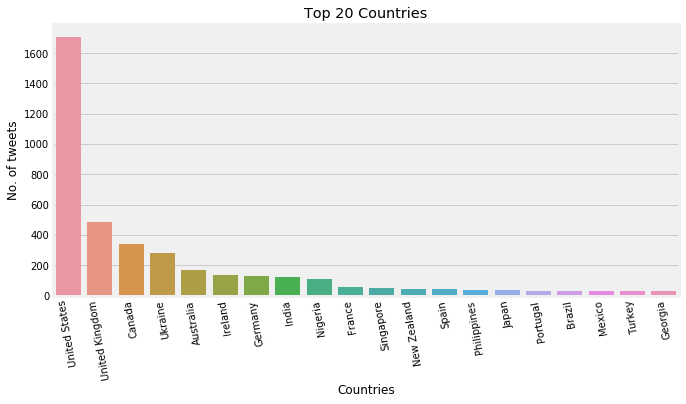

In [11]:
print ('Top 20 countries at 27/02/2022')
PlotCountries(twt_27_02_pd)

Top 20 countries at 26/02/2022


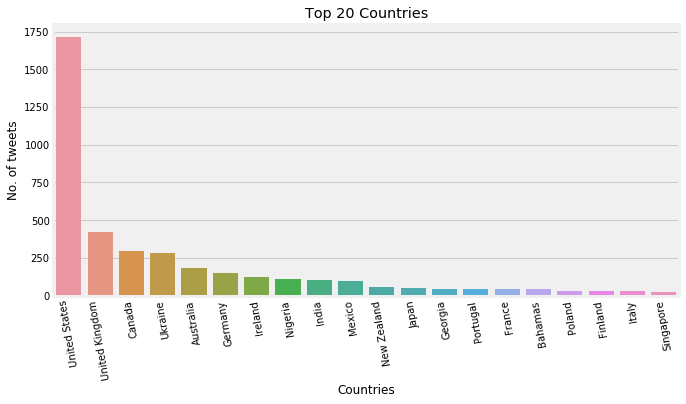

In [39]:
print ('Top 20 countries at 26/02/2022')
PlotCountries(twt_26_02_pd)

Top 20 countries at 25/02/2022


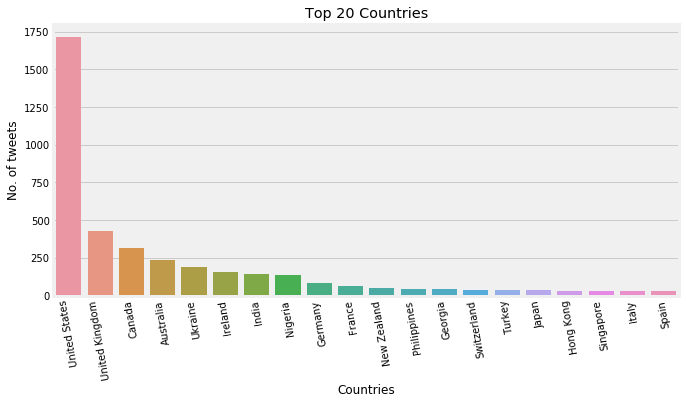

In [40]:
print ('Top 20 countries at 25/02/2022')
PlotCountries(twt_25_02_pd)

Top 20 countries at 24/02/2022


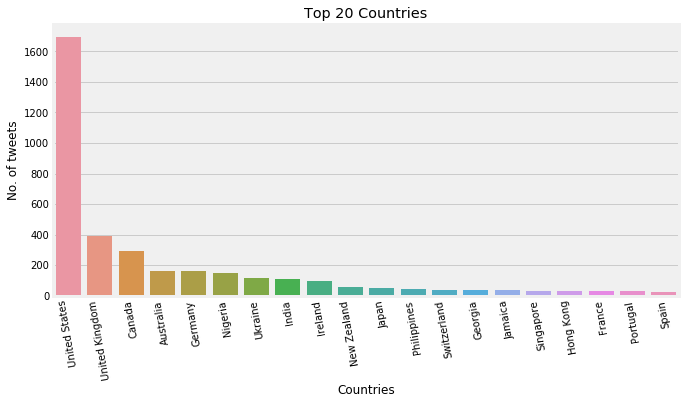

In [41]:
print ('Top 20 countries at 24/02/2022')
PlotCountries(twt_24_02_pd)

In [19]:
# Print the value counts of Country column
print(twt_27_02_pd["country_code"].value_counts())
print(twt_26_02_pd["country_code"].value_counts())
print(twt_25_02_pd["country_code"].value_counts())
print(twt_24_02_pd["country_code"].value_counts())

unknown    45416
US          1708
GB           484
CA           343
UA           280
           ...  
BJ             1
MW             1
AW             1
CI             1
SY             1
Name: country_code, Length: 144, dtype: int64
unknown    45366
US          1716
GB           422
CA           293
UA           285
           ...  
MS             1
KZ             1
DZ             1
HT             1
VI             1
Name: country_code, Length: 136, dtype: int64
unknown    45421
US          1717
GB           431
CA           314
AU           233
           ...  
ML             1
VI             1
GG             1
AM             1
GY             1
Name: country_code, Length: 147, dtype: int64
unknown    45750
US          1697
GB           391
CA           294
AU           164
           ...  
KW             1
CW             1
BZ             1
NI             1
ET             1
Name: country_code, Length: 140, dtype: int64


In [7]:
# Create our contextual stop words
tfidf_stops = ["ukraine","russia","would","russian","ukrainian","get","one","via","see","says","take"]
# Initialize a Tf-idf Vectorizer
vectorizer_27 = TfidfVectorizer(max_features=10000,stop_words = tfidf_stops)
# Fit and transform the vectorizer
tfidf_matrix_27 = vectorizer_27.fit_transform(twt_27_02_pd["text_preprocessed_tokenized(str)"].apply(lambda x: np.str_(x)))
# Display the matrix
display(tfidf_matrix_27)
# Create a DataFrame for tf-idf vectors 
tfidf_df_27 = pd.DataFrame(tfidf_matrix_27.toarray(), columns= vectorizer_27.get_feature_names_out())
display(tfidf_df_27.head())

<49998x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 490744 stored elements in Compressed Sparse Row format>

,abandon,abandoned,abandoning,abandons,abbott,abc,abe,abeg,abhorrent,abi,...,zero,zhytomyr,zil,zionist,zionists,zip,zone,zones,zoo,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Initialize a Tf-idf Vectorizer
vectorizer_26 = TfidfVectorizer(max_features=10000,stop_words = tfidf_stops)
# Fit and transform the vectorizer
tfidf_matrix_26 = vectorizer_26.fit_transform(twt_26_02_pd["text_preprocessed_tokenized(str)"].apply(lambda x: np.str_(x)))
# Display the matrix
display(tfidf_matrix_26)
# Create a DataFrame for tf-idf vectors 
tfidf_df_26 = pd.DataFrame(tfidf_matrix_26.toarray(), columns= vectorizer_26.get_feature_names_out())
display(tfidf_df_26.head())

<49997x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 478036 stored elements in Compressed Sparse Row format>

,aaron,abandon,abandoned,abandoning,abandons,abbott,abby,abc,abe,abedi,...,zelinski,zelinsky,zero,zinchenko,zionist,zip,zone,zones,zoo,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Initialize a Tf-idf Vectorizer
vectorizer_25 = TfidfVectorizer(max_features=10000,stop_words = tfidf_stops)
# Fit and transform the vectorizer
tfidf_matrix_25 = vectorizer_25.fit_transform(twt_25_02_pd["text_preprocessed_tokenized(str)"].apply(lambda x: np.str_(x)))
# Display the matrix
display(tfidf_matrix_25)
# Create a DataFrame for tf-idf vectors 
tfidf_df_25 = pd.DataFrame(tfidf_matrix_25.toarray(), columns= vectorizer_25.get_feature_names_out())
display(tfidf_df_25.head())

<49999x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 487092 stored elements in Compressed Sparse Row format>

,aapl,aaron,abandon,abandoned,abandoning,abased,abc,abeg,abetting,abhorrent,...,zhytomyr,zielinski,zinchenko,zionist,zip,zog,zone,zones,zoo,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Initialize a Tf-idf Vectorizer
vectorizer_24 = TfidfVectorizer(max_features=10000,stop_words = tfidf_stops)
# Fit and transform the vectorizer
tfidf_matrix_24 = vectorizer_24.fit_transform(twt_24_02_pd["text_preprocessed_tokenized(str)"].apply(lambda x: np.str_(x)))
# Display the matrix
display(tfidf_matrix_24)
# Create a DataFrame for tf-idf vectors 
tfidf_df_24 = pd.DataFrame(tfidf_matrix_24.toarray(), columns= vectorizer_24.get_feature_names_out())
display(tfidf_df_24.head())

<49999x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 475614 stored elements in Compressed Sparse Row format>

,aaron,abandon,abandoned,abandoning,abandonment,abbott,abc,abeg,abhorrent,abi,...,zilch,zimbabwe,zinchenko,zinoleesky,zionist,zionists,zmiinyi,zone,zones,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Create a new DataFrame called frequencies
frequencies_27 = pd.DataFrame(tfidf_matrix_27.sum(axis=0).T,index=vectorizer_27.get_feature_names_out(),columns=['total frequency'])
frequencies_27.sort_values(by='total frequency',ascending=False, inplace=True)
print ("27/04/2022")
display(frequencies_27.head(20))

frequencies_26 = pd.DataFrame(tfidf_matrix_26.sum(axis=0).T,index=vectorizer_26.get_feature_names_out(),columns=['total frequency'])
frequencies_26.sort_values(by='total frequency',ascending=False, inplace=True)
print ("26/04/2022")
display(frequencies_26.head(20))

frequencies_25 = pd.DataFrame(tfidf_matrix_25.sum(axis=0).T,index=vectorizer_25.get_feature_names_out(),columns=['total frequency'])
frequencies_25.sort_values(by='total frequency',ascending=False, inplace=True)
print ("25/04/2022")
display(frequencies_25.head(20))

frequencies_24 = pd.DataFrame(tfidf_matrix_24.sum(axis=0).T,index=vectorizer_24.get_feature_names_out(),columns=['total frequency'])
frequencies_24.sort_values(by='total frequency',ascending=False, inplace=True)
print ("24/04/2022")
display(frequencies_24.head(20))

27/04/2022


,total frequency
putin,957.572860
people,878.621875
war,850.104242
support,600.881789
world,592.758899
nato,564.405535
help,555.317809
invasion,547.734617
like,502.543794
amp,485.223641


26/04/2022


,total frequency
people,992.784463
putin,966.984670
war,849.900406
help,638.320527
support,586.425308
world,580.688054
nato,546.008633
invasion,508.984882
like,489.402555
amp,470.594225


25/04/2022


,total frequency
putin,991.767446
people,989.495138
war,872.328773
nato,727.678717
invasion,639.193324
help,609.345858
world,574.551486
support,532.923133
amp,527.739463
stand,508.348344


24/04/2022


,total frequency
putin,1110.084013
people,1051.082649
war,972.934010
invasion,741.543878
nato,711.788360
amp,531.837184
world,523.165329
like,500.543346
help,478.518635
stand,465.250924


In [16]:
def GetWordCloud(frequencies):
    # Join the indexes
    frequent_words = " ".join(frequencies.index)+" "

    # Initialize the word cloud
    wc = WordCloud(width = 350, height = 350, min_font_size = 10, max_words=1000, background_color ='white')

    # Generate the world clouds for each type of label
    tweets_wc = wc.generate(frequent_words)

    # Plot the world cloud                     
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(tweets_wc, interpolation="bilinear") 
    plt.axis("off") 
    plt.title("Common words in the tweets")
    plt.tight_layout(pad = 0) 
    plt.show() 

WordCloud for 24/03/2022


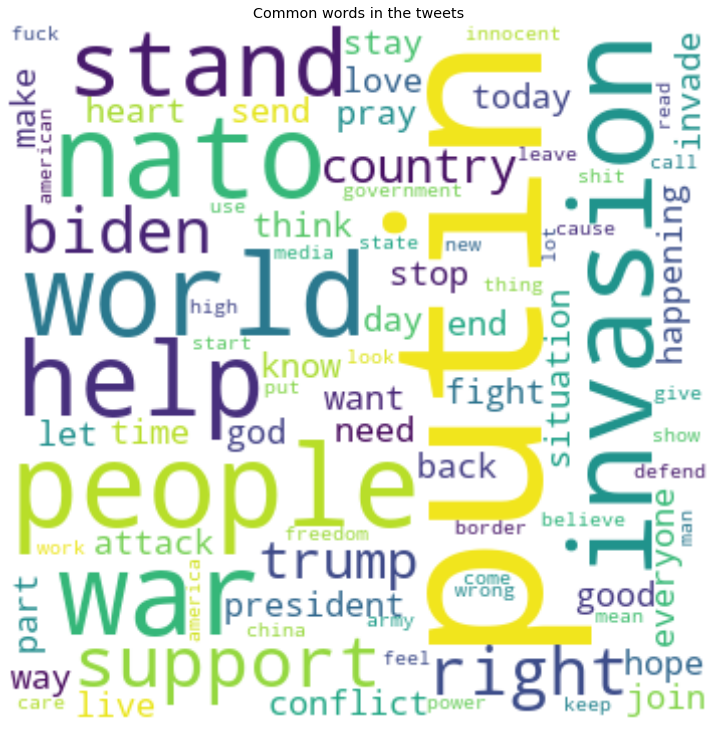

In [43]:
print ("WordCloud for 24/03/2022")
GetWordCloud(frequencies_24)

WordCloud 25/03/2022


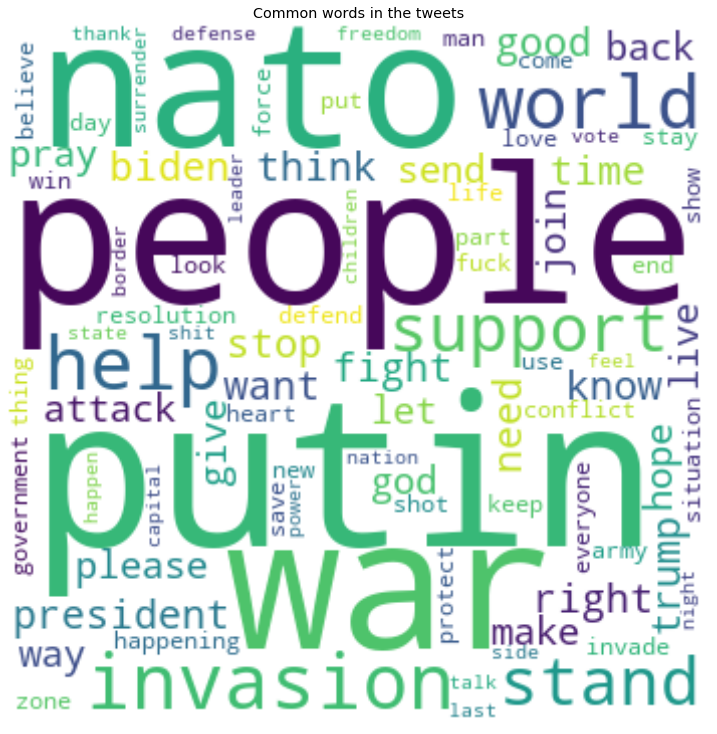

In [44]:
print ("WordCloud 25/03/2022")
GetWordCloud(frequencies_25)

WordCloud 26/03/2022


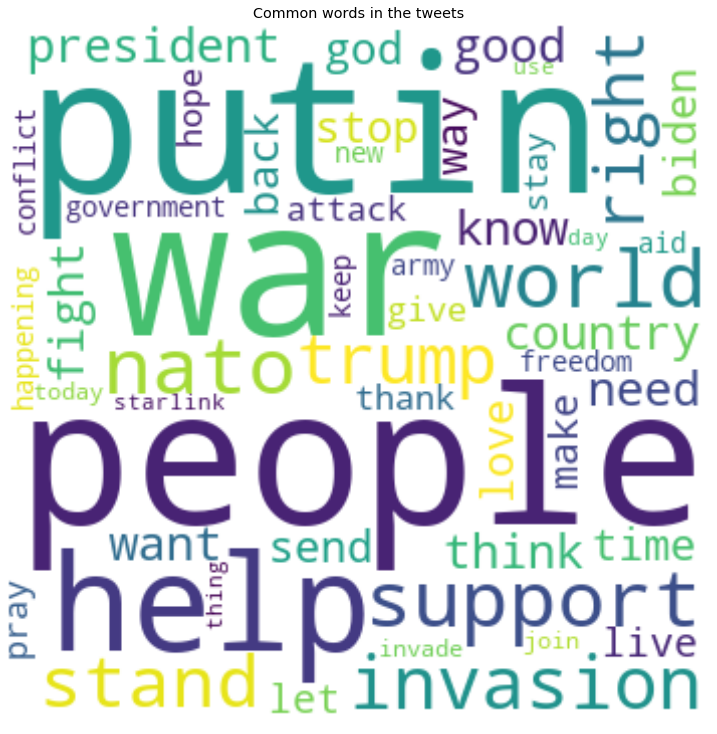

In [46]:
print ("WordCloud 26/03/2022")
GetWordCloud(frequencies_26)

WordCloud 27/03/2022


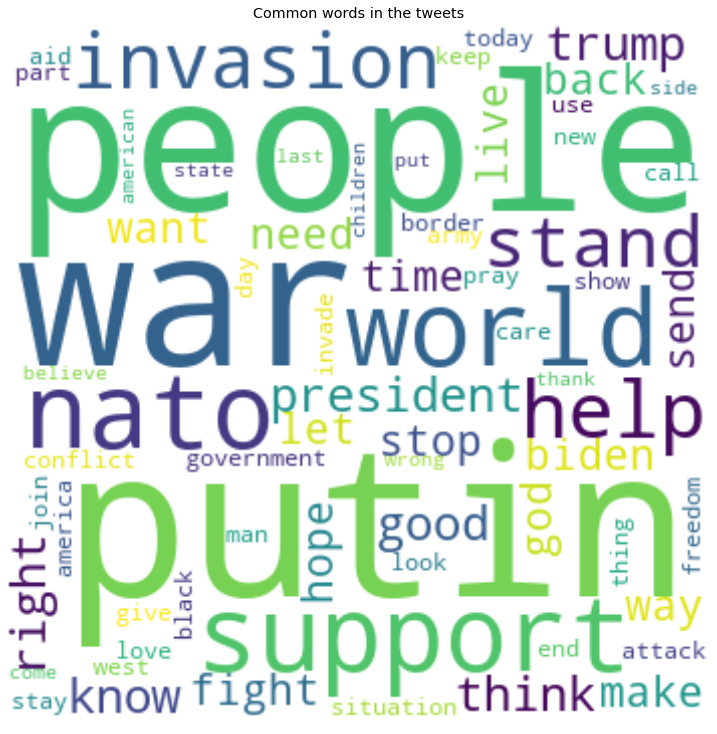

In [45]:
print ("WordCloud 27/03/2022")
GetWordCloud(frequencies_27)

## SENTIMENT ANALYSIS

### TEXTBLOB SENTIMENT ANALYZER

In [102]:
#Create a function to get the subjectivity of the Tweet
def Subjectivity(twt):
    return TextBlob(twt).sentiment.subjectivity
#Create a function to get the polarity of the Tweet
def Polarity(twt):
    return TextBlob(twt).sentiment.polarity
#Create two new columns called 'Subjectivity' and 'Polarity'
twt_27_02_pd['Subjectivity'] = twt_27_02_pd['text_preprocessed_tokenized(str)'].apply(Subjectivity)
twt_27_02_pd['Polarity'] = twt_27_02_pd['text_preprocessed_tokenized(str)'].apply(Polarity)

twt_26_02_pd['Subjectivity'] = twt_26_02_pd['text_preprocessed_tokenized(str)'].apply(Subjectivity)
twt_26_02_pd['Polarity'] = twt_26_02_pd['text_preprocessed_tokenized(str)'].apply(Polarity)

twt_25_02_pd['Subjectivity'] = twt_25_02_pd['text_preprocessed_tokenized(str)'].apply(Subjectivity)
twt_25_02_pd['Polarity'] = twt_25_02_pd['text_preprocessed_tokenized(str)'].apply(Polarity)

twt_24_02_pd['Subjectivity'] = twt_24_02_pd['text_preprocessed_tokenized(str)'].apply(Subjectivity)
twt_24_02_pd['Polarity'] = twt_24_02_pd['text_preprocessed_tokenized(str)'].apply(Polarity)

In [43]:
#Get the Tweet's sentiment
def Sentiment(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else: 
        return 'Positive'

In [104]:
#Create a Sentiment column
twt_27_02_pd['Sentiment'] = twt_27_02_pd['Polarity'].apply(Sentiment)
twt_26_02_pd['Sentiment'] = twt_26_02_pd['Polarity'].apply(Sentiment)
twt_25_02_pd['Sentiment'] = twt_25_02_pd['Polarity'].apply(Sentiment)
twt_24_02_pd['Sentiment'] = twt_24_02_pd['Polarity'].apply(Sentiment)

In [5]:
print ('---------------------------------------------')
print ('Sentiment Value Counts for 27/02/2022')
print (twt_27_02_pd['Sentiment'].value_counts())
print ('---------------------------------------------')
print ('Sentiment Value Counts for 26/02/2022')
print (twt_26_02_pd['Sentiment'].value_counts())
print ('---------------------------------------------')
print ('Sentiment Value Counts for 25/02/2022')
print (twt_25_02_pd['Sentiment'].value_counts())
print ('---------------------------------------------')
print ('Sentiment Value Counts for 24/02/2022')
print (twt_24_02_pd['Sentiment'].value_counts())

---------------------------------------------
Sentiment Value Counts for 27/02/2022
Neutral     19664
Positive    18536
Negative    11798
Name: Sentiment, dtype: int64
---------------------------------------------
Sentiment Value Counts for 26/02/2022
Neutral     19990
Positive    18896
Negative    11111
Name: Sentiment, dtype: int64
---------------------------------------------
Sentiment Value Counts for 25/02/2022
Neutral     20293
Positive    18036
Negative    11670
Name: Sentiment, dtype: int64
---------------------------------------------
Sentiment Value Counts for 24/02/2022
Neutral     20136
Positive    17398
Negative    12465
Name: Sentiment, dtype: int64


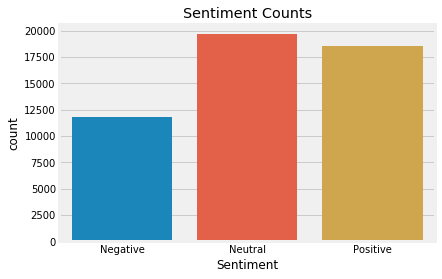

In [8]:
# Visualize the Label counts
sns.countplot(twt_27_02_pd["Sentiment"] , order = ['Negative' , 'Neutral', 'Positive'])
plt.title("Sentiment Counts")
plt.show()

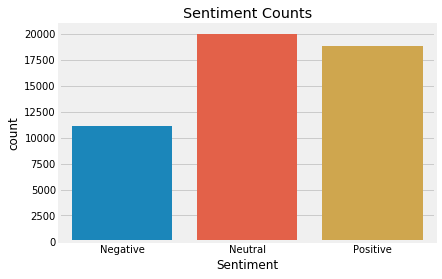

In [9]:
# Visualize the Label counts
sns.countplot(twt_26_02_pd["Sentiment"], order = ['Negative' , 'Neutral', 'Positive'])
plt.title("Sentiment Counts")
plt.show()

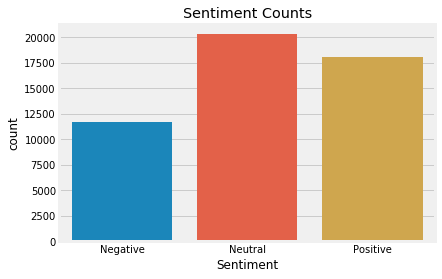

In [10]:
# Visualize the Label counts
sns.countplot(twt_25_02_pd["Sentiment"], order = ['Negative' , 'Neutral', 'Positive'])
plt.title("Sentiment Counts")
plt.show()

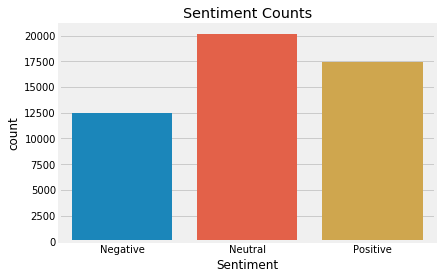

In [11]:
# Visualize the Label counts
sns.countplot(twt_24_02_pd["Sentiment"], order = ['Negative' , 'Neutral', 'Positive'])
plt.title("Sentiment Counts")
plt.show()

### VADER SENTIMENT ANALYZER

In [66]:
analyzer = SentimentIntensityAnalyzer()

In [67]:
def Sentiment_Vader(score):
    if score < -0.05:
        return 'Negative'
    elif score > 0.35:
        return 'Positive'
    else: 
        return 'Neutral'

In [68]:
scores =  []
compound_list = []
positive_list = []
negative_list = []
neutral_list = []
for i in range (twt_27_02_pd['text_preprocessed_tokenized(str)'].shape[0]):
    compound = analyzer.polarity_scores(str(twt_27_02_pd['text_preprocessed_tokenized(str)'][i]))["compound"]
    pos = analyzer.polarity_scores(str(twt_27_02_pd['text_preprocessed_tokenized(str)'][i]))["pos"]
    neg = analyzer.polarity_scores(str(twt_27_02_pd['text_preprocessed_tokenized(str)'][i]))["neg"]
    neu = analyzer.polarity_scores(str(twt_27_02_pd['text_preprocessed_tokenized(str)'][i]))["neu"]
    
    scores.append({'Compound':compound,
                        'Positive':pos,
                        'Negative':neg,
                        'Neutral':neu})
sentiments_score_27 = pd.DataFrame.from_dict(scores)
twt_27_02_pd = twt_27_02_pd.join(sentiments_score_27)

In [69]:
scores =  []
compound_list = []
positive_list = []
negative_list = []
neutral_list = []
for i in range (twt_26_02_pd['text_preprocessed_tokenized(str)'].shape[0]):
    compound = analyzer.polarity_scores(str(twt_26_02_pd['text_preprocessed_tokenized(str)'][i]))["compound"]
    pos = analyzer.polarity_scores(str(twt_26_02_pd['text_preprocessed_tokenized(str)'][i]))["pos"]
    neg = analyzer.polarity_scores(str(twt_26_02_pd['text_preprocessed_tokenized(str)'][i]))["neg"]
    neu = analyzer.polarity_scores(str(twt_26_02_pd['text_preprocessed_tokenized(str)'][i]))["neu"]
    
    scores.append({'Compound':compound,
                        'Positive':pos,
                        'Negative':neg,
                        'Neutral':neu})
sentiments_score_26 = pd.DataFrame.from_dict(scores)
twt_26_02_pd = twt_26_02_pd.join(sentiments_score_26)

In [70]:
scores =  []
compound_list = []
positive_list = []
negative_list = []
neutral_list = []
for i in range (twt_25_02_pd['text_preprocessed_tokenized(str)'].shape[0]):
    compound = analyzer.polarity_scores(str(twt_25_02_pd['text_preprocessed_tokenized(str)'][i]))["compound"]
    pos = analyzer.polarity_scores(str(twt_25_02_pd['text_preprocessed_tokenized(str)'][i]))["pos"]
    neg = analyzer.polarity_scores(str(twt_25_02_pd['text_preprocessed_tokenized(str)'][i]))["neg"]
    neu = analyzer.polarity_scores(str(twt_25_02_pd['text_preprocessed_tokenized(str)'][i]))["neu"]
    
    scores.append({'Compound':compound,
                        'Positive':pos,
                        'Negative':neg,
                        'Neutral':neu})
sentiments_score_25 = pd.DataFrame.from_dict(scores)
twt_25_02_pd = twt_25_02_pd.join(sentiments_score_25)

In [71]:
scores =  []
compound_list = []
positive_list = []
negative_list = []
neutral_list = []
for i in range (twt_24_02_pd['text_preprocessed_tokenized(str)'].shape[0]):
    compound = analyzer.polarity_scores(str(twt_24_02_pd['text_preprocessed_tokenized(str)'][i]))["compound"]
    pos = analyzer.polarity_scores(str(twt_24_02_pd['text_preprocessed_tokenized(str)'][i]))["pos"]
    neg = analyzer.polarity_scores(str(twt_24_02_pd['text_preprocessed_tokenized(str)'][i]))["neg"]
    neu = analyzer.polarity_scores(str(twt_24_02_pd['text_preprocessed_tokenized(str)'][i]))["neu"]
    
    scores.append({'Compound':compound,
                        'Positive':pos,
                        'Negative':neg,
                        'Neutral':neu})
sentiments_score_24 = pd.DataFrame.from_dict(scores)
twt_24_02_pd = twt_24_02_pd.join(sentiments_score_24)

In [72]:
twt_27_02_pd['Sentiment_Vader'] = twt_27_02_pd['Compound'].apply(Sentiment_Vader)
twt_26_02_pd['Sentiment_Vader'] = twt_26_02_pd['Compound'].apply(Sentiment_Vader)
twt_25_02_pd['Sentiment_Vader'] = twt_25_02_pd['Compound'].apply(Sentiment_Vader)
twt_24_02_pd['Sentiment_Vader'] = twt_24_02_pd['Compound'].apply(Sentiment_Vader)

In [6]:
print ('---------------------------------------------')
print ('Sentiment Value Counts for 27/02/2022')
print (twt_27_02_pd['Sentiment_Vader'].value_counts())
print ('---------------------------------------------')
print ('Sentiment Value Counts for 26/02/2022')
print (twt_26_02_pd['Sentiment_Vader'].value_counts())
print ('---------------------------------------------')
print ('Sentiment Value Counts for 25/02/2022')
print (twt_25_02_pd['Sentiment_Vader'].value_counts())
print ('---------------------------------------------')
print ('Sentiment Value Counts for 24/02/2022')
print (twt_24_02_pd['Sentiment_Vader'].value_counts())

---------------------------------------------
Sentiment Value Counts for 27/02/2022
Negative    19726
Neutral     15934
Positive    14338
Name: Sentiment_Vader, dtype: int64
---------------------------------------------
Sentiment Value Counts for 26/02/2022
Negative    19541
Neutral     15593
Positive    14863
Name: Sentiment_Vader, dtype: int64
---------------------------------------------
Sentiment Value Counts for 25/02/2022
Negative    20188
Neutral     16177
Positive    13634
Name: Sentiment_Vader, dtype: int64
---------------------------------------------
Sentiment Value Counts for 24/02/2022
Negative    21280
Neutral     16163
Positive    12556
Name: Sentiment_Vader, dtype: int64


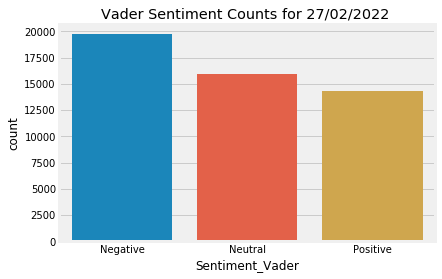

In [4]:
sns.countplot(twt_27_02_pd["Sentiment_Vader"] , order = ['Negative' , 'Neutral', 'Positive'])
plt.title("Vader Sentiment Counts for 27/02/2022 ")
plt.show()

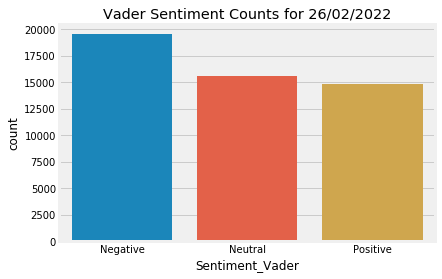

In [5]:
sns.countplot(twt_26_02_pd["Sentiment_Vader"] , order = ['Negative' , 'Neutral', 'Positive'])
plt.title("Vader Sentiment Counts for 26/02/2022")
plt.show()

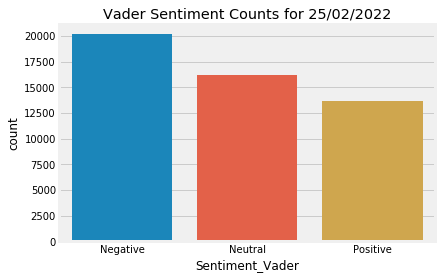

In [6]:
sns.countplot(twt_25_02_pd["Sentiment_Vader"] , order = ['Negative' , 'Neutral', 'Positive'])
plt.title("Vader Sentiment Counts for 25/02/2022")
plt.show()

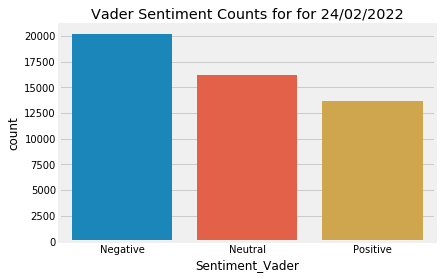

In [7]:
sns.countplot(twt_25_02_pd["Sentiment_Vader"] , order = ['Negative' , 'Neutral', 'Positive'])
plt.title("Vader Sentiment Counts for for 24/02/2022")
plt.show()

In [20]:
#Deleting some more columns that i didn't need after all
twt_27_02_pd.drop(columns = ['retweet_count' ,'favorite_count'], inplace = True)
twt_26_02_pd.drop(columns = ['retweet_count' ,'favorite_count'], inplace = True)
twt_25_02_pd.drop(columns = ['retweet_count' ,'favorite_count'], inplace = True)
twt_24_02_pd.drop(columns = ['retweet_count' ,'favorite_count'], inplace = True)

In [21]:
twt_24_02_pd.head()

,timestamp,tweet_text,location,text_preprocessed_tokenized,text_preprocessed_tokenized(str),country_code,Subjectivity,Polarity,Sentiment,Compound,Positive,Negative,Neutral,Sentiment_Vader
0,2022-02-24 23:59:59,b'HELP DONATE TO ME FOR UKRAINE.. WALLET ADDRE...,unknown,"['donate', 'wallet', 'address']",donate wallet address,unknown,0.0,0.0,Neutral,0.0000,0.000,0.000,1.000,Neutral
1,2022-02-24 23:59:59,b'Hope the people of Russia hold Their leader/...,"Columbia, MO","['people', 'russia', 'hold', 'accountable', 'w...",people russia hold accountable wish safety peo...,unknown,0.0,0.0,Neutral,0.8402,0.562,0.000,0.438,Positive
2,2022-02-24 23:59:59,b'Due to Covid ....#Ukraine #Russia war will b...,"Accra, Ghana","['covid', 'war', 'held', 'online', 'thank']",covid war held online thank,unknown,0.0,0.0,Neutral,-0.3400,0.266,0.415,0.319,Negative
3,2022-02-24 23:59:59,b'@Still_Terror @Mr__davinz You no get use Mak...,"camp nou, anfield","['get', 'use', 'make', 'send', 'ukraine', 'per...",get use make send ukraine per nigerian agent,unknown,0.0,0.0,Neutral,0.0000,0.000,0.000,1.000,Neutral
4,2022-02-24 23:59:59,"b""@VarunKrRana @ANI that's left to the UN Peac...",Bangalore,"['left', 'peace', 'talking', 'everything', 'su...",left peace talking everything sun except ukrai...,unknown,0.0,0.0,Neutral,-0.1531,0.257,0.301,0.441,Negative


In [22]:
#Passing my processed tweets to a csv file for later use,without doing the whole process again
twt_24_02_pd.to_csv("twt_24_02_processed.csv", index = False)
twt_25_02_pd.to_csv("twt_25_02_processed.csv", index = False)
twt_26_02_pd.to_csv("twt_26_02_processed.csv", index = False)
twt_27_02_pd.to_csv("twt_27_02_processed.csv", index = False)

# PREPARING THE DATASETS FOR THE MACHINE LEARNING MODELS

In [3]:
#Reading my stored csv files (the processed tweets)
twt_27_02_pd = pd.read_csv("twt_27_02_processed.csv")
twt_26_02_pd = pd.read_csv("twt_26_02_processed.csv")
twt_25_02_pd = pd.read_csv("twt_25_02_processed.csv")
twt_24_02_pd = pd.read_csv("twt_24_02_processed.csv")

In [96]:
#Creating new DataFrames consisting only of the processed text and the sentiment-related columns
twt_27_02_sentiments = twt_27_02_pd.filter(['text_preprocessed_tokenized(str)','Sentiment','Sentiment_Vader'], axis=1)
twt_26_02_sentiments = twt_26_02_pd.filter(['text_preprocessed_tokenized(str)','Sentiment','Sentiment_Vader'], axis=1)
twt_25_02_sentiments = twt_25_02_pd.filter(['text_preprocessed_tokenized(str)','Sentiment','Sentiment_Vader'], axis=1)
twt_24_02_sentiments = twt_24_02_pd.filter(['text_preprocessed_tokenized(str)','Sentiment','Sentiment_Vader'], axis=1)

### CREATING A NEW COLUMN TO THE NEW DATAFRAMES WITH THE FINAL SENTIMENT.

In [25]:
#IF THE SENTIMENTS FROM TEXTBLOB (Sentiment) and Vader (Sentiment_Vader) are the same,
#this is the final sentiment of the tweet.If they are not the same,the tweets is deleted in this new dataframe

In [107]:
twt_27_02_sentiments['Final_Sentiment'] = twt_27_02_sentiments['Sentiment']
for i in range (twt_27_02_sentiments.shape[0]):
    if twt_27_02_sentiments['Sentiment'][i] == twt_27_02_sentiments['Sentiment_Vader'][i] :
        twt_27_02_sentiments['Final_Sentiment'][i] = twt_27_02_sentiments['Sentiment'][i]
    else:
        twt_27_02_sentiments = twt_27_02_sentiments.drop(i)
twt_27_02_sentiments.head()

,text_preprocessed_tokenized(str),Sentiment,Sentiment_Vader,Final_Sentiment
1,typical republicans country pulling together c...,Negative,Negative,Negative
2,remember war political issue entire world unit...,Positive,Positive,Positive
3,financial calamity sojourn white house,Neutral,Neutral,Neutral
4,russia invades ukraine canada rails olympics a...,Neutral,Neutral,Neutral
5,already provides visa free access,Positive,Positive,Positive


In [108]:
twt_26_02_sentiments['Final_Sentiment'] = twt_26_02_sentiments['Sentiment']
for i in range (twt_26_02_sentiments.shape[0]):
    if twt_26_02_sentiments['Sentiment'][i] == twt_26_02_sentiments['Sentiment_Vader'][i] :
        twt_26_02_sentiments['Final_Sentiment'][i] = twt_26_02_sentiments['Sentiment'][i]
    else:
        twt_26_02_sentiments = twt_26_02_sentiments.drop(i)
twt_26_02_sentiments.head()

,text_preprocessed_tokenized(str),Sentiment,Sentiment_Vader,Final_Sentiment
1,ron johnson knew trump withheld aid ukraine kept,Neutral,Neutral,Neutral
6,research ukraine,Neutral,Neutral,Neutral
9,probably retweeted pretty far dingbat personal...,Positive,Positive,Positive
12,chinese stand ukraine ccp,Neutral,Neutral,Neutral
13,know blackmail asked president look biden pros...,Negative,Negative,Negative


In [109]:
twt_25_02_sentiments['Final_Sentiment'] = twt_25_02_sentiments['Sentiment']
for i in range (twt_25_02_sentiments.shape[0]):
    if twt_25_02_sentiments['Sentiment'][i] == twt_25_02_sentiments['Sentiment_Vader'][i] :
        twt_25_02_sentiments['Final_Sentiment'][i] = twt_25_02_sentiments['Sentiment'][i]
    else:
        twt_25_02_sentiments = twt_25_02_sentiments.drop(i)
twt_25_02_sentiments.head()

,text_preprocessed_tokenized(str),Sentiment,Sentiment_Vader,Final_Sentiment
1,ambassador russian amb crazy context putin ask...,Negative,Negative,Negative
3,sanctions russia could florida paying price,Neutral,Neutral,Neutral
4,fuck prayers ukraine posts open purse,Negative,Negative,Negative
7,want excellent summary conflict stands current...,Positive,Positive,Positive
8,canadians pestering trudeau directly help sinc...,Positive,Positive,Positive


In [110]:
twt_24_02_sentiments['Final_Sentiment'] = twt_24_02_sentiments['Sentiment']
for i in range (twt_24_02_sentiments.shape[0]):
    if twt_24_02_sentiments['Sentiment'][i] == twt_24_02_sentiments['Sentiment_Vader'][i] :
        twt_24_02_sentiments['Final_Sentiment'][i] = twt_24_02_sentiments['Sentiment'][i]
    else:
        twt_24_02_sentiments = twt_24_02_sentiments.drop(i)
twt_24_02_sentiments.head()

,text_preprocessed_tokenized(str),Sentiment,Sentiment_Vader,Final_Sentiment
0,donate wallet address,Neutral,Neutral,Neutral
3,get use make send ukraine per nigerian agent,Neutral,Neutral,Neutral
7,stand fuck actually already gone done,Negative,Negative,Negative
8,sources using stay date,Neutral,Neutral,Neutral
9,troops stayed behind former border ukraine rus...,Positive,Positive,Positive


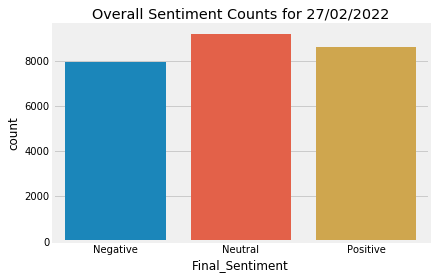

In [29]:
sns.countplot(twt_27_02_sentiments["Final_Sentiment"] , order = ['Negative' , 'Neutral', 'Positive'])
plt.title("Overall Sentiment Counts for 27/02/2022")
plt.show()

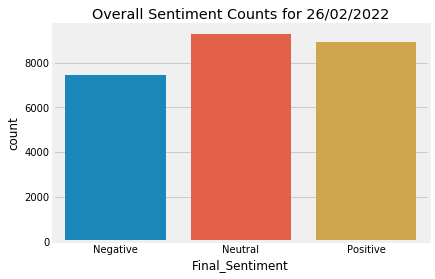

In [28]:
sns.countplot(twt_26_02_sentiments["Final_Sentiment"] , order = ['Negative' , 'Neutral', 'Positive'])
plt.title("Overall Sentiment Counts for 26/02/2022")
plt.show()

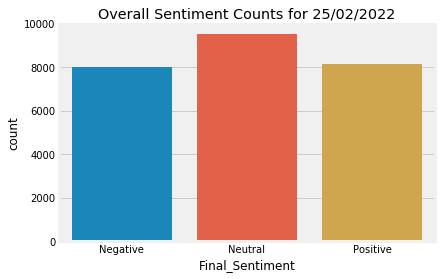

In [30]:
sns.countplot(twt_25_02_sentiments["Final_Sentiment"] , order = ['Negative' , 'Neutral', 'Positive'])
plt.title("Overall Sentiment Counts for 25/02/2022")
plt.show()

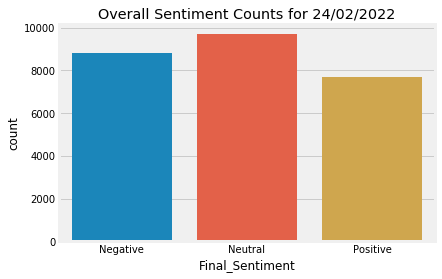

In [31]:
sns.countplot(twt_24_02_sentiments["Final_Sentiment"] , order = ['Negative' , 'Neutral', 'Positive'])
plt.title("Overall Sentiment Counts for 24/02/2022")
plt.show()

In [111]:
twt_24_02_sentiments.to_csv("twt_24_02_sentiments.csv")
twt_25_02_sentiments.to_csv("twt_25_02_sentiments.csv")
twt_26_02_sentiments.to_csv("twt_26_02_sentiments.csv")
twt_27_02_sentiments.to_csv("twt_27_02_sentiments.csv")

# BUILDING MACHINE LEARNING MODELS

In [31]:
twt_27_02_sentiments = pd.read_csv("twt_27_02_sentiments.csv")
twt_26_02_sentiments = pd.read_csv("twt_26_02_sentiments.csv")
twt_25_02_sentiments = pd.read_csv("twt_25_02_sentiments.csv")
twt_24_02_sentiments = pd.read_csv("twt_24_02_sentiments.csv")

In [34]:
# Encode the labels
le = preprocessing.LabelEncoder()
twt_24_02_sentiments["Sentiment_enc"] = le.fit_transform(twt_24_02_sentiments["Final_Sentiment"])
twt_25_02_sentiments["Sentiment_enc"] = le.fit_transform(twt_25_02_sentiments["Final_Sentiment"])
twt_26_02_sentiments["Sentiment_enc"] = le.fit_transform(twt_26_02_sentiments["Final_Sentiment"])
# Display the encoded labels
display(twt_24_02_sentiments[["Sentiment_enc"]].head())
#The labels are:
#Negative:0 ,Neutral:1 ,Positive:2

,Sentiment_enc
0,1
1,1
2,0
3,1
4,2


In [35]:
#Create a new dataframe,consistinf of the dataframes twt_24_02_sentiments, twt_25_02_sentiments, twt_26_02_sentiments ,to train my models on it
twt_24_25_26 = pd.concat([twt_24_02_sentiments, twt_25_02_sentiments, twt_26_02_sentiments ])
twt_24_25_26 = twt_24_25_26.reset_index(drop=True)

In [36]:
# Select the features and the target
X = twt_24_25_26["text_preprocessed_tokenized(str)"]
y = twt_24_25_26["Sentiment_enc"]

In [37]:
# Dividing our data in train and test ones
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

In [38]:
# Create the tf-idf vectorizer
model_vectorizer = TfidfVectorizer()

In [39]:
X_train = model_vectorizer.fit_transform(X_train.apply(lambda x: np.str_(x)))
X_test  = model_vectorizer.transform(X_test.apply(lambda x: np.str_(x)))

### BERNOULLI NAYVE BAYES MODEL

In [11]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
y_pred1 = BNBmodel.predict(X_test)
print(classification_report(y_test, y_pred1))
cf_matrix_bnb = confusion_matrix(y_test, y_pred1)
y_score1 = BNBmodel.predict_proba(X_test)
roc_auc_score(y_test , y_score1 ,multi_class = "ovr")
print(cf_matrix)

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      4867
           1       0.86      0.90      0.88      5702
           2       0.90      0.84      0.87      4960

    accuracy                           0.87     15529
   macro avg       0.87      0.87      0.87     15529
weighted avg       0.87      0.87      0.87     15529

[[4199  435  233]
 [ 311 5147  244]
 [ 377  404 4179]]


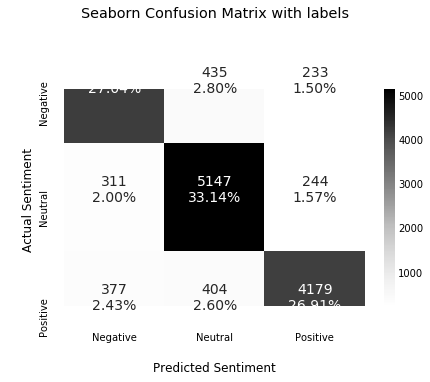

In [43]:
#group_names = ['True Neg','False Pos','False Neg','True Pos','True Pos','True Pos','True Pos','True Pos','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_bnb.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_bnb.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(3,3)

ax = sns.heatmap(cf_matrix_bnb, annot=labels,annot_kws={"size": 14}, fmt='' ,cmap='Greys')

ax.set_title('Seaborn Confusion Matrix with labels\n\n\n\n');
ax.set_xlabel('\nPredicted Sentiment')
ax.set_ylabel('\nActual Sentiment ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['\n\nNegative','\n\nNeutral','\n\nPositive'])
ax.yaxis.set_ticklabels(['Negative\n','Neutral\n','Positive\n'])

## Display the visualization of the Confusion Matrix.
plt.show()

### LINEAR SUPPORT VECTOR CLASSIFIER MODEL

In [15]:
SVC = LinearSVC(multi_class = 'ovr')
SVC.fit(X_train, y_train)
y_pred2 = SVC.predict(X_test)
print(classification_report(y_test, y_pred2))
cf_matrix_svm = confusion_matrix(y_test, y_pred2)
print (cf_matrix_svm)

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      4867
           1       0.97      0.99      0.98      5702
           2       0.98      0.97      0.98      4960

    accuracy                           0.98     15529
   macro avg       0.98      0.98      0.98     15529
weighted avg       0.98      0.98      0.98     15529

[[4737   81   49]
 [  36 5619   47]
 [  47   88 4825]]


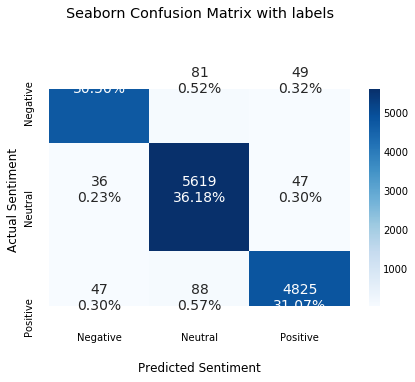

<Figure size 396x288 with 0 Axes>

In [44]:
#group_names = ['True Neg','False Pos','False Neg','True Pos','True Pos','True Pos','True Pos','True Pos','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_svm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_svm.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(3,3)

ax = sns.heatmap(cf_matrix_svm, annot= labels, annot_kws={"size": 14}, fmt='' ,cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n\n\n');
ax.set_xlabel('\nPredicted Sentiment')
ax.set_ylabel('Actual Sentiment ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['\n\nNegative','\n\nNeutral','\n\nPositive'])
ax.yaxis.set_ticklabels(['Negative\n','Neutral\n','Positive\n'])

## Display the visualization of the Confusion Matrix.
plt.figure(figsize=(5.5,4))
plt.show()

### DECISION TREE CLASSIFIER

In [40]:
Dtc = DecisionTreeClassifier()
Dtc.fit(X_train, y_train)
y_pred4 = Dtc.predict(X_test)
print(classification_report(y_test, y_pred4))
cf_matrix = confusion_matrix(y_test, y_pred4)
print (cf_matrix)
y_score4 = Dtc.predict_proba(X_test)
roc_auc_score(y_test , y_score4 ,multi_class = "ovr")

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      4867
           1       0.88      0.92      0.90      5702
           2       0.83      0.83      0.83      4960

    accuracy                           0.85     15529
   macro avg       0.85      0.85      0.85     15529
weighted avg       0.85      0.85      0.85     15529

[[3835  379  653]
 [ 225 5267  210]
 [ 547  320 4093]]


0.8852801983740698

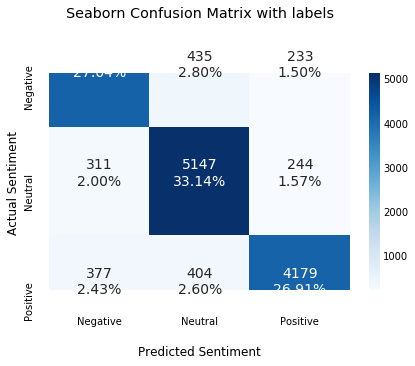

In [46]:
#group_names = ['True Neg','False Pos','False Neg','True Pos','True Pos','True Pos','True Pos','True Pos','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(3,3)

ax = sns.heatmap(cf_matrix, annot=labels,annot_kws={"size": 14}, fmt='' ,cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n\n');
ax.set_xlabel('\nPredicted Sentiment')
ax.set_ylabel('Actual Sentiment ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['\n\nNegative','\n\nNeutral','\n\nPositive'])
ax.yaxis.set_ticklabels(['Negative\n','Neutral\n','Positive\n'])


## Display the visualization of the Confusion Matrix.
plt.show()

### RANDOM FOREST CLASSIFIER (WITH AND WITHOUT TUNING)

In [47]:
Rfc = RandomForestClassifier()
Rfc.fit(X_train, y_train)
y_pred5 = Rfc.predict(X_test)
print(classification_report(y_test, y_pred5))
cf_matrix = confusion_matrix(y_test, y_pred5)
print (cf_matrix)
y_score5 = Rfc.predict_proba(X_test)
roc_auc_score(y_test , y_score5 ,multi_class = "ovr")

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      4867
           1       0.92      0.94      0.93      5702
           2       0.90      0.90      0.90      4960

    accuracy                           0.91     15529
   macro avg       0.91      0.91      0.91     15529
weighted avg       0.91      0.91      0.91     15529

[[4311  243  313]
 [ 147 5374  181]
 [ 284  201 4475]]


0.9828762232943028

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
model = RandomForestClassifier()
param_vals = {'max_depth': [200, 500, 800, 1100], 'n_estimators': [100, 200, 300, 400]}
random_rf = RandomizedSearchCV(estimator=model, param_distributions=param_vals,
                              n_iter=10, scoring='accuracy', cv=5,
                              refit=True, n_jobs=-1)

#Training and prediction

random_rf.fit(X_train, y_train)
model_Evaluate(random_rf)
y_pred5_2 = random_rf.predict(X_test)
y_score5_2 = random_rf.predict_proba(X_test)
roc_auc_score(y_test , y_score5_2 ,multi_class = "ovo")

### 1)LOGISTIC REGRESSION
### 2)LOGISTIC REGRESSION WITH HYPERPARAMETER TUNING

In [12]:
LR = LogisticRegression(solver = 'lbfgs',max_iter = 500 ,multi_class='ovr')
LR.fit(X_train, y_train)
y_pred6 = LR.predict(X_test)
print(classification_report(y_test, y_pred6))
cf_matrix = confusion_matrix(y_test, y_pred6)
print (cf_matrix)
y_score6 = LR.predict_proba(X_test)
roc_auc_score(y_test , y_score6 ,multi_class = "ovr")

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      4867
           1       0.92      0.97      0.94      5702
           2       0.96      0.93      0.94      4960

    accuracy                           0.94     15529
   macro avg       0.95      0.94      0.94     15529
weighted avg       0.94      0.94      0.94     15529

[[4524  239  104]
 [  86 5520   96]
 [  98  252 4610]]


0.9926453277503592

In [21]:
#Train again a LR model,after using some hyperparameter tuning with the GridSearch method
from sklearn.model_selection import GridSearchCV
LR_G = LogisticRegression(solver = 'lbfgs',max_iter = 500 ,multi_class='ovr')
grid_vals = {'C': [0.001,0.01,0.1,1]}
grid_lr = GridSearchCV(estimator=LR_G, param_grid=grid_vals, scoring='accuracy', 
                       cv=6, refit=True, return_train_score=True) 

#Training and Prediction

grid_lr.fit(X_train, y_train)
y_pred7 = grid_lr.predict(X_test)
print(classification_report(y_test, y_pred7))
cf_matrix = confusion_matrix(y_test, y_pred7)
print (cf_matrix)
y_score7 = grid_lr.predict_proba(X_test)
roc_auc_score(y_test , y_score7 ,multi_class = "ovr")

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      7049
           1       0.91      0.98      0.94     12084
           2       0.94      0.92      0.93     10866

    accuracy                           0.93     29999
   macro avg       0.93      0.91      0.92     29999
weighted avg       0.93      0.93      0.92     29999

[[ 5892   608   549]
 [   66 11888   130]
 [  296   583  9987]]


0.9867142371401368

### ΝΟW LET'S SAVE THE 2 BEST MODELS TO A FILE (SVM AND LOGISTIC REGRESSION)

In [35]:
file1 = 'svc.sav'
pickle.dump(SVC, open(file1, 'wb'))

In [14]:
file2 = 'lr.sav'
pickle.dump(LR, open(file2, 'wb'))

### WE RECALL THE MODELS TO MAKE SENTIMENT PREDICTIONS ON THE 27/02/2022 DATASET AND COMPARE THEM WITH THE TEXTBLOB ONES

In [30]:
#Reload the models
svc_re = pickle.load(open('svc.sav', 'rb'))
lr_re = pickle.load(open('lr.sav', 'rb'))

In [16]:
# Define our features (X_re) and labels (y_re)
X_re = twt_27_02_sentiments['text_preprocessed_tokenized(str)']
twt_27_02_sentiments["Sentiment_enc"] = le.fit_transform(twt_27_02_sentiments["Sentiment"])
y_re = twt_27_02_sentiments['Sentiment_enc']

In [17]:
X_re = model_vectorizer.transform(X_re.apply(lambda x: np.str_(x)))

In [18]:
#Testing the best model first,the SVC
y_pred_re = svc_re.predict(X_re)
# Print the evaluation metrics for the dataset.
print(classification_report(y_re, y_pred_re))
# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(y_re, y_pred_re)
print (cf_matrix)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      7929
           1       0.96      0.99      0.97      9169
           2       0.98      0.97      0.98      8601

    accuracy                           0.97     25699
   macro avg       0.98      0.97      0.97     25699
weighted avg       0.97      0.97      0.97     25699

[[7659  176   94]
 [  63 9045   61]
 [  87  176 8338]]


In [19]:
#Testing the second best model,Logistic Regression
y_pred_re2 = lr_re.predict(X_re)
# Print the evaluation metrics for the dataset.
print(classification_report(y_re, y_pred_re2))
# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(y_re, y_pred_re2)
print (cf_matrix)

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      7929
           1       0.91      0.97      0.94      9169
           2       0.96      0.92      0.94      8601

    accuracy                           0.94     25699
   macro avg       0.94      0.94      0.94     25699
weighted avg       0.94      0.94      0.94     25699

[[7329  445  155]
 [ 148 8872  149]
 [ 184  482 7935]]
